In [228]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [229]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [230]:
#df = pd.read_csv("../input/annp2dataset/Training.csv")
df = pd.read_csv("datasets/Training.csv")
print(df.shape)
#ho 68528 istanti temporali e 7 features

(68528, 7)


In [231]:
scaler = MinMaxScaler()
ndf = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [232]:
def build_sequences(df, target_labels, window, stride, telescope):
    # the telescope tells us how many parameters i want to predict in the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    # target_labels allows to choose how many sensors we are going to predict in the future
    temp_label = df[target_labels].copy().values
    padding_len = len(df) % window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df) % window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0, len(temp_df)-window-telescope, stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [233]:
ndf['Sponginess'].copy().values.shape

(68528,)

In [234]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
        axs[i].legend()
    plt.show()

# Models

In [235]:
models = {}
models_ar = {}
results = {}

### Import trained models

In [236]:
# Import models
from tensorflow.keras.models import load_model

models['350x1gru'] = load_model('final_models/350x1gru')
models['800x2conv+4gru'] = load_model('final_models/800x2conv+4gru')
models['1000x5gru'] = load_model('final_models/1000x5gru')

## Testing

In [237]:
predictions = {}

target_labels = ndf.columns
window = 1200
stride = 10
telescope=864

X = ndf.to_numpy()
X = np.float32(X)

In [238]:
# For each model, compute the prediction on the last part of the time series
for key, model in models.items():
    input = model.layers[0].input.shape
    output = model.layers[-1].output.shape
    print(f'{key} \t Input Shape:\t{input}')
    print(f'\t\t Output Shape: \t{output}')

    future = X[-input[1]:]
    future = np.expand_dims(future, axis=0)
    pred = model.predict(future)

    print(f'\t\t Pred. Shape \t{pred.shape}')
    predictions[key] = pred

350x1gru 	 Input Shape:	(None, 350, 7)
		 Output Shape: 	(None, 1200, 7)
		 Pred. Shape 	(1, 1200, 7)
800x2conv+4gru 	 Input Shape:	(None, 800, 7)
		 Output Shape: 	(None, 864, 7)
		 Pred. Shape 	(1, 864, 7)
1000x5gru 	 Input Shape:	(None, 1000, 7)
		 Output Shape: 	(None, 864, 7)
		 Pred. Shape 	(1, 864, 7)


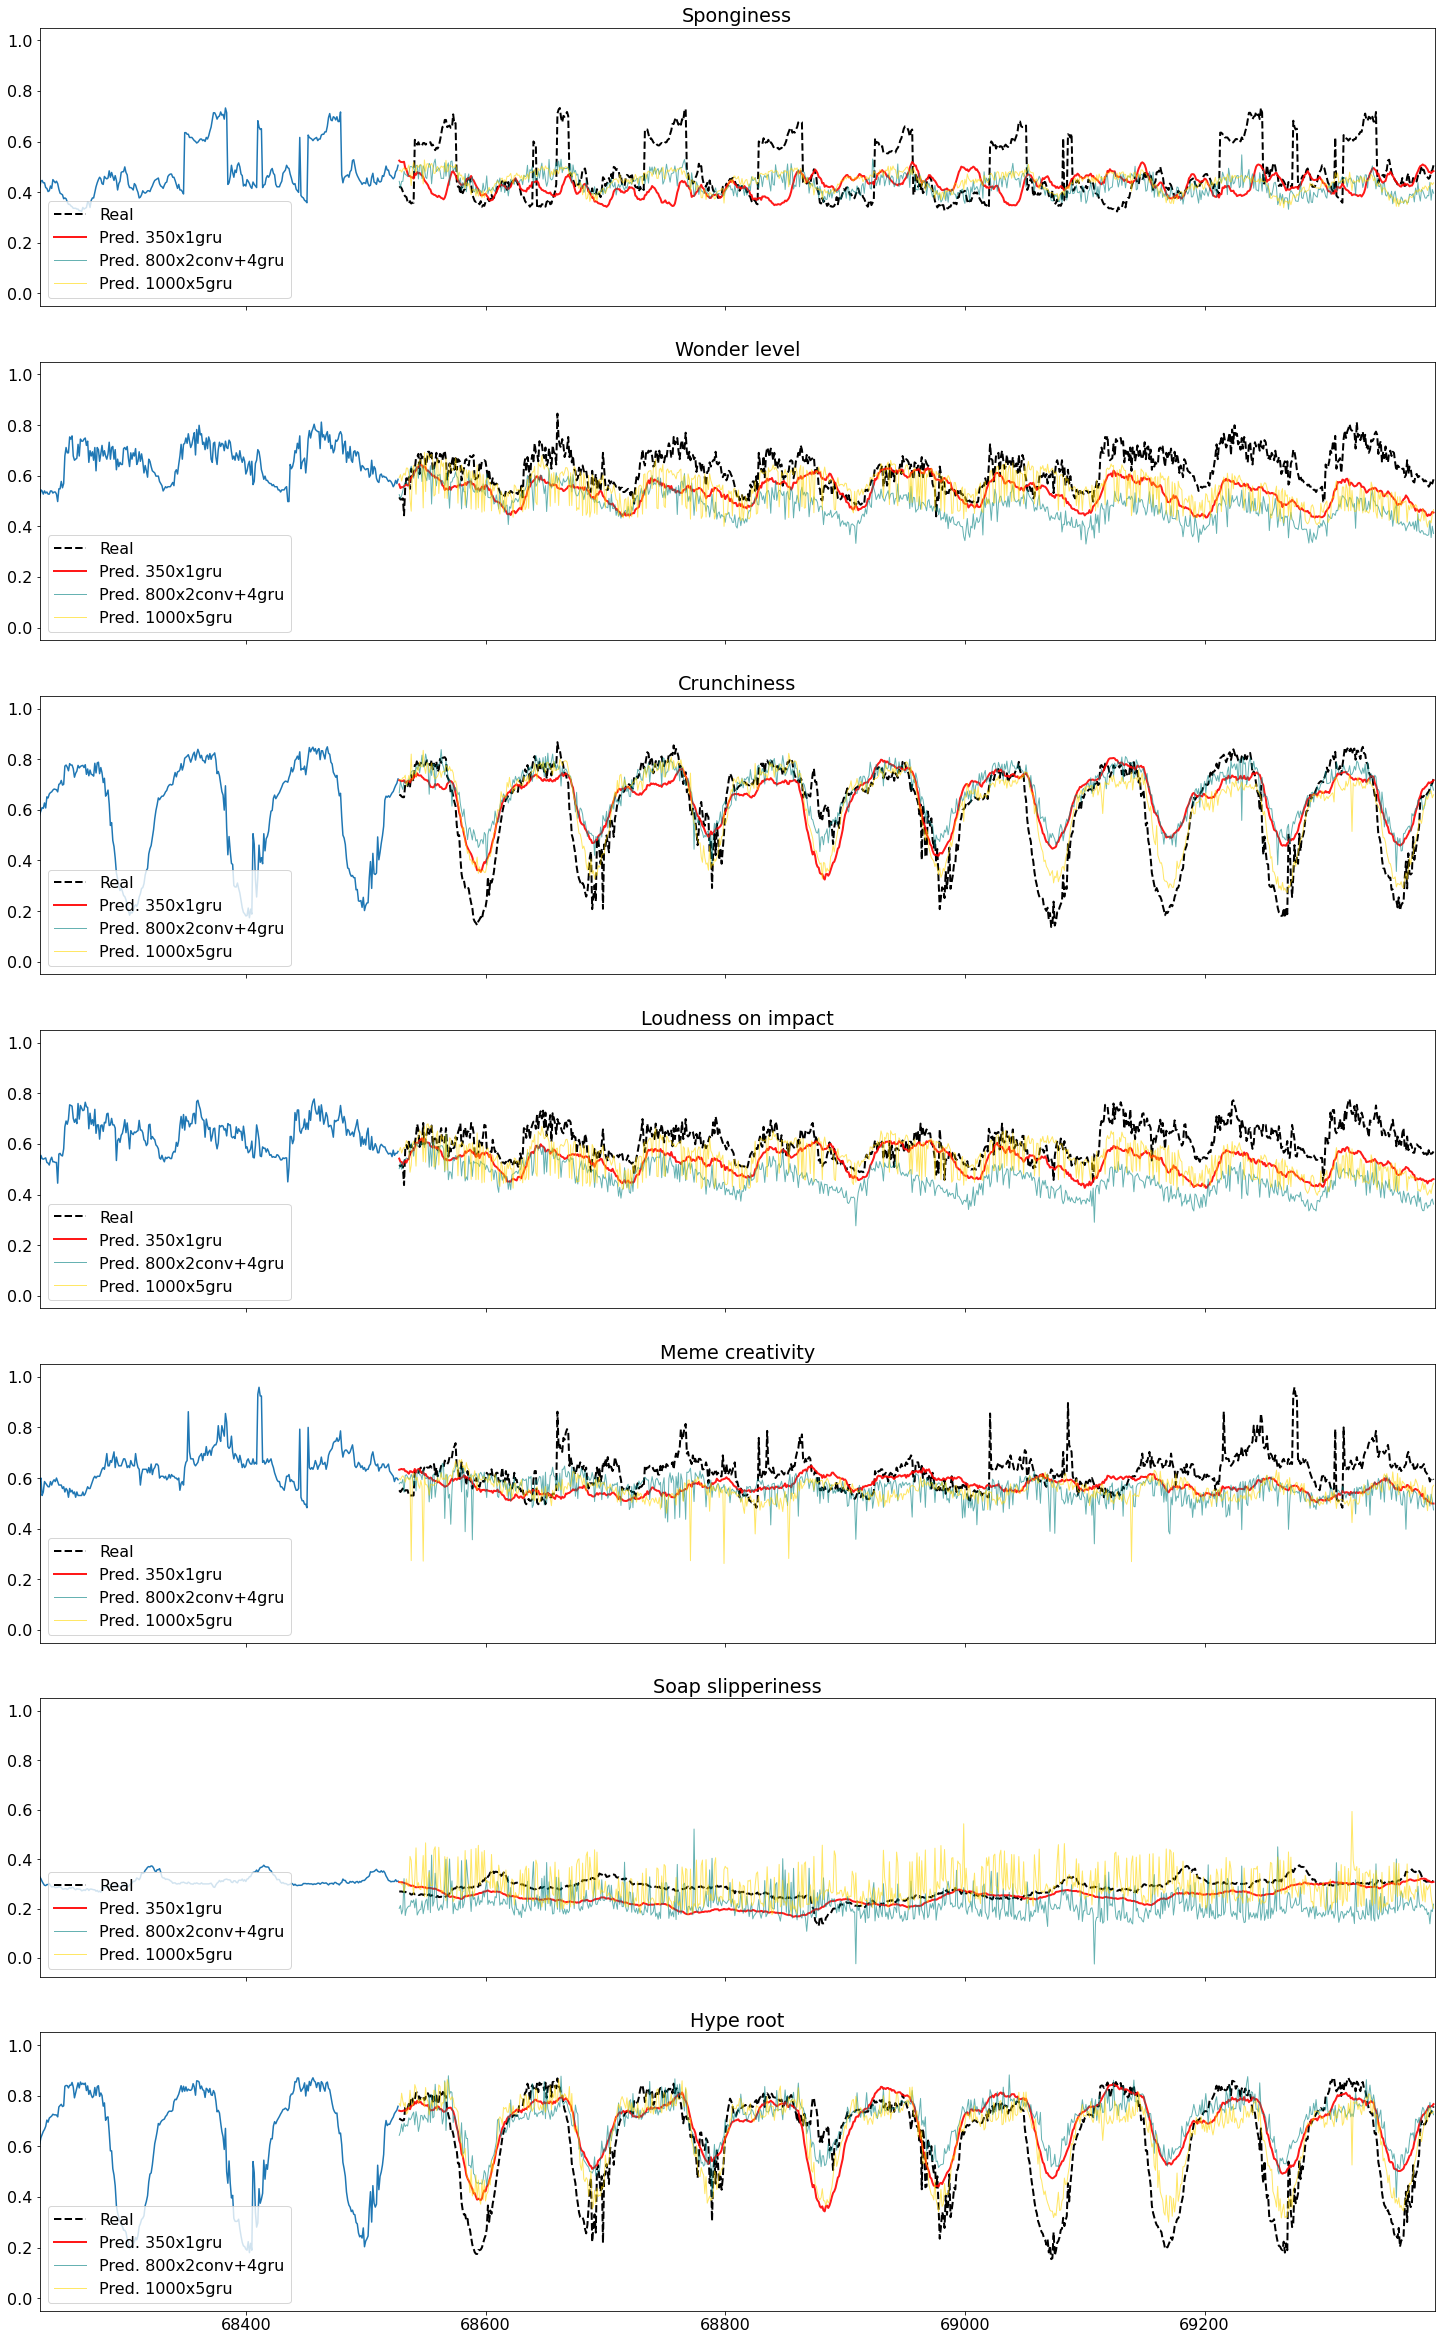

In [239]:
def inspect_multivariate_prediction(X, preds, columns, telescope):
    past_window = X.shape[0]
    """preds must be a dictionary (key, pred[])"""

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(25,6 * 7))
    for i, col in enumerate(columns):
        # Plot past
        axs[i].plot(
            np.arange(past_window),
            X[:,i])
        # Plot true future
        axs[i].plot(
            np.arange(past_window, past_window+telescope),
            X[-telescope:,i],
            color='black', ls='--', lw=2, label='Real')
        # For each model, plot predicted future
        for j, (key, pred) in enumerate(preds.items()):
            axs[i].plot(
                np.arange(past_window, past_window+telescope),
                pred[0,:telescope,i],
                lw=(2 if j == 0 else 1), alpha=(0.9 if j == 0 else 0.6),
                color=('red' if j == 0 else 'teal' if j == 1 else 'gold'), label=f'Pred. {key}')
        axs[i].set_title(col)
        # Display only the most "recent" predictions and portion of the timeseries
        axs[i].set_xlim(max(0, past_window - 300), past_window+telescope)
        axs[i].legend(loc='lower left')
    plt.show()

inspect_multivariate_prediction(X, predictions, target_labels, 864)